In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [83]:
raw_data = pd.read_csv('train.csv')

In [84]:
raw_data.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [85]:
processed_data = pd.DataFrame()
time = pd.to_datetime(raw_data["created"])
processed_data['created'] = (time.dt.hour * 60 + time.dt.minute) * 60 + time.dt.second

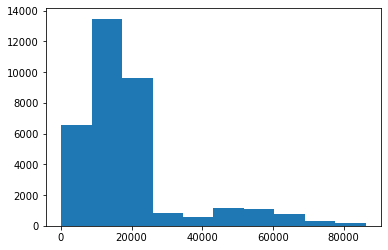

In [86]:
plt.hist(processed_data['created'])
plt.show()

**Сведём время к нормальному распределению**

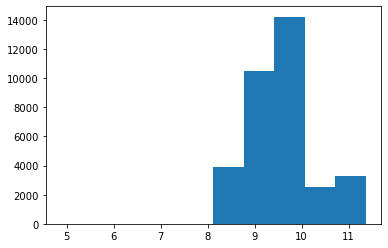

In [87]:
processed_data['created'] = np.log(processed_data['created'])
plt.hist(processed_data['created'])
plt.show()

In [88]:
processed_data['bathrooms'] = raw_data['bathrooms']
processed_data['bedrooms'] = raw_data['bedrooms']
processed_data['price'] = raw_data['price']

**Оставим 25 самых популярных лейблов**

In [89]:
labels = []
for i in raw_data['features'].values:
    for j in i[1:-1].split(', '):
         labels.append(j)
labels = np.array(labels)
a, b = np.unique(labels, return_counts=True)
labels = [i[1] for i in sorted(zip(b, a))[-25:]]

In [90]:
for i in labels:
    processed_data[i] = np.array([i in j for j in raw_data['features']]).astype('int32')

**Посмотрим на разные районы города**

In [91]:
neighborhoods = pd.read_csv('AB_NYC_2019.csv')[['latitude', 'longitude', 'neighbourhood_group']]

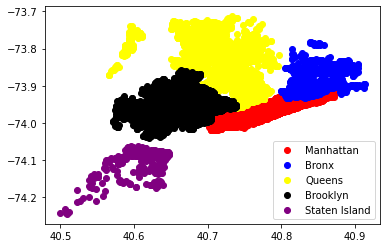

In [92]:
cur = neighborhoods[neighborhoods['neighbourhood_group'] == "Manhattan"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='red', label="Manhattan")
cur = neighborhoods[neighborhoods['neighbourhood_group'] == "Bronx"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='blue', label="Bronx")
cur = neighborhoods[neighborhoods['neighbourhood_group'] == "Queens"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='yellow', label="Queens")
cur = neighborhoods[neighborhoods['neighbourhood_group'] == "Brooklyn"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='black', label="Brooklyn")
cur = neighborhoods[neighborhoods['neighbourhood_group'] == "Staten Island"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='purple', label="Staten Island")
plt.legend()
plt.show()

**С помощью KNN разметим каким районам принадлежат квартиры из датасета**

In [93]:
knn_model = KNeighborsClassifier()
knn_model = knn_model.fit(neighborhoods[['latitude', 'longitude']], neighborhoods['neighbourhood_group'])

In [94]:
processed_data['neighbourhood'] = knn_model.predict(raw_data[['latitude', 'longitude']])
processed_data['latitude'] = raw_data['latitude']
processed_data['longitude'] = raw_data['longitude']

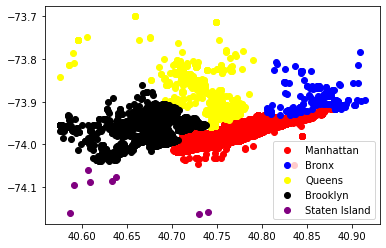

In [96]:
neighborhoods = processed_data[(processed_data['latitude'] > 40.55) & (processed_data['latitude'] < 40.95) & (processed_data['longitude'] < -73.7) & (processed_data['longitude'] > -74.2)]
cur = neighborhoods[neighborhoods['neighbourhood'] == "Manhattan"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='red', label="Manhattan")
cur = neighborhoods[neighborhoods['neighbourhood'] == "Bronx"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='blue', label="Bronx")
cur = neighborhoods[neighborhoods['neighbourhood'] == "Queens"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='yellow', label="Queens")
cur = neighborhoods[neighborhoods['neighbourhood'] == "Brooklyn"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='black', label="Brooklyn")
cur = neighborhoods[neighborhoods['neighbourhood'] == "Staten Island"]
plt.scatter(x=cur['latitude'], y=cur['longitude'], c='purple', label="Staten Island")
plt.legend()
plt.show()

In [16]:
for i in np.unique(processed_data['neighbourhood'].values):
    processed_data[i] = (processed_data['neighbourhood'] == i).astype('int32')
processed_data = processed_data.drop(['neighbourhood'], axis=1)
processed_data = processed_data.loc[processed_data['latitude'] != 0]
processed_data['target'] = raw_data['TARGET']

In [17]:
def metric(model, x, y):
    weights = np.array([0.3276 if i == 'low' else 1.0 if i == 'medium' else 2.9245 for i in y])
    return accuracy_score(y, model.predict(x), sample_weight=weights)

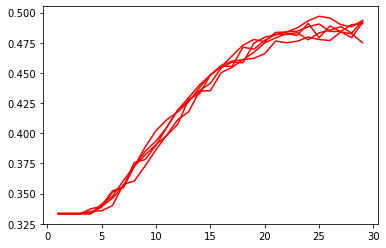

In [18]:
history = []
for depth in range(1, 30):
    model = RandomForestClassifier(max_depth=depth, n_estimators=50)
    history.append(cross_val_score(model, processed_data.drop(['target'], axis=1), 
                                   processed_data['target'], cv=5, scoring=metric))
plt.plot(range(1, 30), history, c='red')
plt.show()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(processed_data.drop(['target'], axis=1), processed_data['target'], test_size=0.2)
model = RandomForestClassifier(max_depth=26, n_estimators=50)
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)
history = []
mx = -1
weights = np.array([0.3276 if i == 'low' else 1.0 if i == 'medium' else 2.9245 for i in y_test])
for p1 in range(50):
    for p2 in range(50):
        y_pred_labels = np.array(['high' if i[0] > p1 / 50 else 'low' if i[1] > p2 / 50 else 'medium' for i in y_pred])
        score = accuracy_score(y_test, y_pred_labels, sample_weight=weights)
        if score > mx:
            mx = score
            p1_mx, p2_mx = p1, p2

In [20]:
mx

0.5912930730004858